### Постановка задачи

Научимся предсказывать пользовательскую оценку отеля по тексту отзыва. [Студенческое соревнование на Kaggle](https://www.kaggle.com/t/3e8fa6cec6d048bf8e93fb72e441d88c)

Данные: отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Дан текст отзыва и пользовательская оценка отеля.

Главная метрика - Mean Absolute Error (MAE).

Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10.

Использовать любые данные для обучения кроме предоставленных организаторами строго запрещено. В последней части можно использовать предобученные модели из библиотеки `transformers`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from warnings import filterwarnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sns.set(style='darkgrid')
filterwarnings('ignore')

In [ ]:
PATH_TO_TRAIN_DATA = '/content/drive/MyDrive/Intro to DL/train.csv'

In [ ]:
df = pd.read_csv(PATH_TO_TRAIN_DATA)
df['negative'] = df['negative'].replace('No Negative', '')
df['positive'] = df['positive'].replace('No Positive', '')
df.head(10)

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7
5,00025fd423c6e8340fc876a7a77eafe3,Hotel is under reconstruction and should be c...,Location is excellent for congress activities,6.3
6,0003541ffa154f07b3257bcfba814a4b,Noise from the trains and road but ok for one...,Great location to tube station and local shop...,8.8
7,0003c867f284bb21b14d1430903dfc49,,Great location friendly staff and lovely acco...,10.0
8,0005bc3bc317755b5773821f44564f59,I known you re renovating but having concierg...,Staff were super helpful and friendly Great l...,9.2
9,0005fc2de921da6c2f7239f701bb8dde,Location of room no phone signal,friendly staff,6.7


*Модель не должна учитывать фразу-заглушку в индексах и при рассчете векторов - заменим на пустую строку отсутствие отзыва в базе*

Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [ ]:
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def process_text(text):
    return [word for word in word_tokenize(text.lower()) if word not in string.punctuation]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


*Далее уберем из текста стоп-слова и проведем лемматизацию (пользуюсь [туториалом](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python?utm_source=adwords_ppc&utm_medium=cpc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=278443377095&utm_targetid=aud-392016246653:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9047023&gclid=Cj0KCQiAuvOPBhDXARIsAKzLQ8G-QRU73mY-UWD1lBd_xsSx-WFkl9L2LSujnM1X6nzGXTbNDZHFv88aAlSUEALw_wcB))*

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords

sw = stopwords.words("english")[:40]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
for word in ['we', 'are', 'the', 'champions']:
  print(wordnet_lemmatizer.lemmatize(word, pos="v"))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
we
be
the
champion


*Соберем всю предобработку в обновленную функцию `process_text_beta`*

In [ ]:
def text_processing(text):
    return [wordnet_lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) \
                    if word not in string.punctuation \
                    and word not in sw
            ]

In [ ]:
df1 = df.copy()
df1['negative'] = df['negative'].apply(text_processing)
df1['positive'] = df['positive'].apply(text_processing)

In [ ]:
df1.head(10)

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,"[there, be, issue, with, the, wifi, connection]",[],7.1
1,00004d18f186bf2489590dc415876f73,"[tv, not, work]",[],7.5
2,0000cf900cbb8667fad33a717e9b1cf4,"[more, pillow]","[beautiful, room, great, location, lovely, staff]",10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,"[very, business]",[location],5.4
4,00025e1aa3ac32edb496db49e76bbd00,"[room, could, do, with, a, bite, of, a, refurb...","[nice, breakfast, handy, for, victoria, train,...",6.7
5,00025fd423c6e8340fc876a7a77eafe3,"[hotel, be, under, reconstruction, and, should...","[location, be, excellent, for, congress, activ...",6.3
6,0003541ffa154f07b3257bcfba814a4b,"[noise, from, the, train, and, road, but, ok, ...","[great, location, to, tube, station, and, loca...",8.8
7,0003c867f284bb21b14d1430903dfc49,[],"[great, location, friendly, staff, and, lovely...",10.0
8,0005bc3bc317755b5773821f44564f59,"[know, re, renovate, but, have, concierge, tuc...","[staff, be, super, helpful, and, friendly, gre...",9.2
9,0005fc2de921da6c2f7239f701bb8dde,"[location, of, room, no, phone, signal]","[friendly, staff]",6.7


In [ ]:
df_train, df_test = train_test_split(df, random_state=1412) # <- для локального тестирования
y_train, y_test = df_train['score'], df_test['score']

### Часть 1.

Логистическая регрессия на TF-IDF векторах текстов

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from scipy.sparse import hstack

In [ ]:
print("Best mean constant is %.4f" % y_train.mean())
print("Train MAE with best mean constant = %.4f" % mean_absolute_error(y_train, y_train.mean() * np.ones(y_train.shape)))

Best mean constant is 8.4005
Train MAE with best mean constant = 1.3146


#### Класс модели TF-IDF

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline

In [ ]:
class TF_IDF_wrapper():
    def text_processing(self, text):
        return [wordnet_lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) \
                        if word not in string.punctuation \
                        and word not in sw
                ]

    def __init__(self, model, need_scaling=False):
        if need_scaling:
            self.model = Pipeline(steps=[
                ('scaling_sparse_data', MaxAbsScaler()),
                ('model', model)
            ])
        else:
            self.model = model
        self.tfidf_vectorizer = TfidfVectorizer(tokenizer=self.text_processing)

    def fit(self, corpus, target):
        self.tfidf_vectorizer.fit(pd.concat([corpus['positive'], corpus['negative']], axis=0))
        self.model.fit(self.transform(corpus), target)
        return self.model

    def transform(self, corpus):
        tfidf_vect_pos = self.tfidf_vectorizer.transform(corpus['positive'])
        tfidf_vect_neg = self.tfidf_vectorizer.transform(corpus['negative'])
        return hstack([tfidf_vect_pos, tfidf_vect_neg])

    def predict(self, corpus):
        return self.model.predict(self.transform(corpus))

**Линейная регрессия без нормирования**

In [ ]:
tfidf_ridge = TF_IDF_wrapper(Ridge(), need_scaling=False)
tfidf_ridge.fit(df_train, y_train)
y_pred = tfidf_ridge.predict(df_test)
mean_absolute_error(y_test, y_pred)

0.8309918880404499

**Линейная регрессия со скейлингом (использую [MaxAbsScaler](https://www.machinecurve.com/index.php/2020/11/23/feature-scaling-with-python-and-sparse-data/#:~:text=offers%20by%20email.-,Using%20the%20MaxAbsScaler%20to%20handle%20Sparse%20Data,-Fortunately%2C%20there%20is), объясняется в этой заметке)**

In [ ]:
tfidf_ridge = TF_IDF_wrapper(Ridge(), need_scaling=True)
tfidf_ridge.fit(df_train, y_train)
y_pred = tfidf_ridge.predict(df_test)
mean_absolute_error(y_test, y_pred)

0.8747363233529493

**Логистическая регрессия**

In [ ]:
tfidf_ridge = TF_IDF_wrapper(LogisticRegression(max_iter=5000, penalty='l2'), need_scaling=False)
tfidf_ridge.fit(df_train, y_train.apply(lambda w: round(w)))
y_pred = tfidf_ridge.predict(df_test)
mean_absolute_error(y_test, y_pred)

0.90592

In [ ]:
PATH_TO_TEST_DATA = '/content/drive/MyDrive/Intro to DL (домашки Маши Тимониной)/Intro to DL HW3/test.csv'

df_real_test = pd.read_csv(PATH_TO_TEST_DATA)
df_real_test['negative'] = df_real_test['negative'].replace('No Negative', '')
df_real_test['positive'] = df_real_test['positive'].replace('No Positive', '')
df_real_test.head(10)

,review_id,negative,positive
0,00026f564b258ad5159aab07c357c4ca,Other than the location everything else was h...,Just the location
1,000278c73da08f4fcb857fcfe4ac6417,No UK TV but this was a minor point as we wer...,Great location very comfortable clean breakfa...
2,000404f843e756fe3b2a477dbefa5bd4,A tiny noisy room VERY deceptively photographed,The breakfast booked the preceding night but ...
3,000a66d32bcf305148d789ac156dd512,Noisy various electrical devices kicking in r...,Great location Nice bathroom
4,000bf1d8c5110701f459ffbedbf0d546,,Great location and friendly staff
5,000c36a6731f1e109864308a7a22be4d,,The personnel was helpfull and cheerful The r...
6,00142074a207aba53ddcc46985f8c0c3,,Standing global
7,0014e8ce0480a083abd0dca4f6d7aca7,N A,Free upgrade in Executive Double room complem...
8,0016fb343fddab24736d7e1d9823e9a5,staff in restaurant has problems with hearing,
9,0018a42d079fed623b58d24b0bde718b,Nothing,Fantastic hotel best I ve stayed in for a whi...


In [ ]:
tfidf_ridge = TF_IDF_wrapper(Ridge(), need_scaling=False)
tfidf_ridge.fit(df, df['score'])
y_pred = tfidf_ridge.predict(df_real_test)
y_pred

array([4.69204883, 9.98486586, 6.23275229, ..., 9.71927263, 7.00833046,
       8.84164028])

In [ ]:
df_real_test['score'] = y_pred
df_tfidf_ridge = df_real_test[['review_id', 'score']]
df_tfidf_ridge

,review_id,score
0,00026f564b258ad5159aab07c357c4ca,4.692049
1,000278c73da08f4fcb857fcfe4ac6417,9.984866
2,000404f843e756fe3b2a477dbefa5bd4,6.232752
3,000a66d32bcf305148d789ac156dd512,7.149432
4,000bf1d8c5110701f459ffbedbf0d546,9.389005
...,...,...
19995,ffe8a7190aee6e3a53ee2e0145a91555,6.019652
19996,ffea0e2b84788c9df755efe8e2bedb23,9.520023
19997,fff3997a85a1eed7ae7a937bc945fcf0,9.719273
19998,fff673fe95ab8f3a0910f112549862e2,7.008330


In [ ]:
df_tfidf_ridge.to_csv('/content/drive/MyDrive/Intro to DL/tfidf_submission1.csv', index=False)

In [ ]:
pd.read_csv('/content/drive/MyDrive/Intro to DL/sample_submission.csv')

,review_id,score
0,00026f564b258ad5159aab07c357c4ca,5.5
1,000278c73da08f4fcb857fcfe4ac6417,5.5
2,000404f843e756fe3b2a477dbefa5bd4,5.5
3,000a66d32bcf305148d789ac156dd512,5.5
4,000bf1d8c5110701f459ffbedbf0d546,5.5
...,...,...
19995,ffe8a7190aee6e3a53ee2e0145a91555,5.5
19996,ffea0e2b84788c9df755efe8e2bedb23,5.5
19997,fff3997a85a1eed7ae7a937bc945fcf0,5.5
19998,fff673fe95ab8f3a0910f112549862e2,5.5


#### **Submission, score**

Предскажем этой моделью тестовые данные из [соревнования](https://www.kaggle.com/t/3e8fa6cec6d048bf8e93fb72e441d88c) и делаем сабмит. Получился скор **0.82807**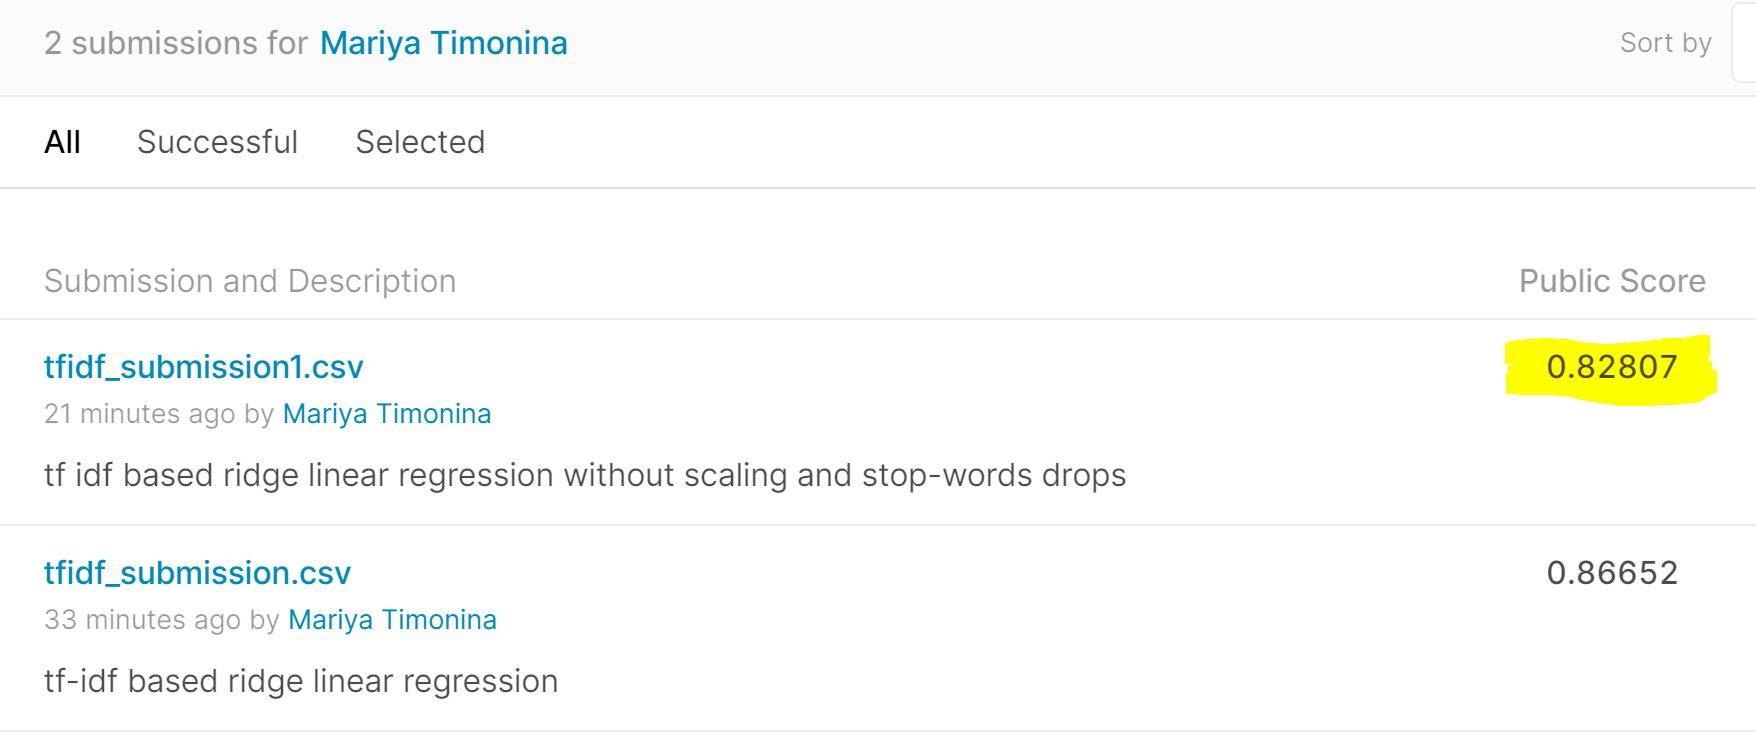

### Часть 2.

Логистическая и линейная регрессия на усредненных Word2Vec векторах. 

In [ ]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import multiprocessing
# import logging  # Setting up the loggings to monitor gensim
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

from gensim.models import Word2Vec

#### Класс модели на взвешенных эмбеддингах слов

Усредняя w2v вектора, мы предполагаем, что каждое слово имеет 1) **равноценный вклад в смысл предложения**, однако это может быть не совсем так. Перевзвесим слова при получении итогового эмбеддинга текста. 2) **В качестве весов IDF (Inverse document frequency)**

In [ ]:
sw = stopwords.words("english")[:40]

In [ ]:
from collections import defaultdict
from math import log10

class Word2Vec_wrapper():
    def text_processing(self, text):
        # lemmatization, puncuation, stop-words cleaning applied to a comment
        return [wordnet_lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) \
                if word not in string.punctuation \
                and word not in sw
                ]

    def prepare_columns(self, corpus):
        new_corpus = corpus[['positive', 'negative']]
        new_corpus['positive'] = new_corpus['positive'].apply(self.text_processing)
        new_corpus['negative'] = new_corpus['negative'].apply(self.text_processing)
        return new_corpus   # contains two columns of word lists

    def compute_idf(self, corpus):
        freq_dict = defaultdict(int)
        for i, line in corpus.iterrows():
            for w in set(line[0]):
              freq_dict[w] += 1
        idf_dict = {}
        for w in freq_dict.keys():
            idf_dict[w] = log10(corpus.shape[0] / (float(freq_dict[w]) + 1))
        return idf_dict

    def weighing(self, weights_dict, word_list):
        '''
        Processing one comment
        Сonverts a list of words into a weighted sum of its w2v vectors (list)
        '''
        answer = np.zeros(self.vector_size)
        counter = 0
        norma = 0.0
        for word in word_list:
            if word in self.embedding_model.wv.key_to_index.keys() and word in weights_dict.keys():
                answer += np.array(self.embedding_model.wv[word]) * weights_dict[word]
                counter += 1
                norma += weights_dict[word]
        if counter == 0:
            return [0] * self.vector_size
        return (answer / norma).tolist()

    def __init__(self, model, wmode='average', vector_size=300, **qwargs):        # Init block starts here
        self.model = model
        self.target_mean = 0.0
        self.target_std = 1.0

        self.wmode = wmode
        self.weights_dict_pos = None
        self.weights_dict_neg = None
        self.vector_size: int = vector_size
        self.embedding_model = Word2Vec(vector_size=self.vector_size, **qwargs)

    def fit(self, corpus, target):
        new_corpus = self.prepare_columns(corpus)
        self.embedding_model.build_vocab(pd.concat([new_corpus['positive'], new_corpus['negative']], axis=0), 
                                        progress_per=10000)
        self.embedding_model.train(pd.concat([new_corpus['positive'], new_corpus['negative']], axis=0), 
                                  total_examples=self.embedding_model.corpus_count, 
                                  epochs=30, report_delay=1)
        # training on weighted sum of word2vec vectors
        if self.wmode == 'idf':
            self.weights_dict_pos = self.compute_idf(new_corpus[['positive']])
            self.weights_dict_neg = self.compute_idf(new_corpus[['negative']])
        else:
            self.weights_dict_pos = dict.fromkeys(self.embedding_model.wv.key_to_index.keys(), 1)
            self.weights_dict_neg = dict.fromkeys(self.embedding_model.wv.key_to_index.keys(), 1)
        # target normalization
        self.target_mean = np.mean(target)
        self.target_std = np.std(target)
        self.model.fit(self.transform(new_corpus, modified=True), (target - self.target_mean) / self.target_std)
        return self.model

    def transform(self, corpus, modified=False):
        # corpus.shape[0] == result.shape[0]
        new_corpus = self.prepare_columns(corpus) if not modified else corpus
        weighed_vect_pos = new_corpus['positive'].apply(lambda x:self.weighing(self.weights_dict_pos, x))
        weighed_vect_neg = new_corpus['negative'].apply(lambda x:self.weighing(self.weights_dict_neg, x))
        return (weighed_vect_pos + weighed_vect_neg).values.tolist()

    def predict(self, corpus):
        return self.target_mean + self.model.predict(self.transform(corpus)) * self.target_std

##### Тестовые запуски

In [ ]:
PATH_TO_TRAIN_DATA = '/content/drive/MyDrive/Intro to DL/train.csv'
df = pd.read_csv(PATH_TO_TRAIN_DATA)
df['negative'] = df['negative'].replace('No Negative', '')
df['positive'] = df['positive'].replace('No Positive', '')
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


In [ ]:
df_train, df_test = train_test_split(df, random_state=1412) # <- для локального тестирования
y_train, y_test = df_train['score'], df_test['score']

Протестируем усреднение простое векторов слов Word2Vec:

In [ ]:
w2v_ridge = Word2Vec_wrapper(model=Ridge(), wmode='average', vector_size=1000, 
                             min_count=4, window=5, alpha=0.03, min_alpha=0.0007)
w2v_ridge.fit(df_train, y_train)
y_pred = w2v_ridge.predict(df_test)
mean_absolute_error(y_test, y_pred)

0.9255290318643834

Теперь взвешенное усреднение Word2Vec:

In [ ]:
for a in [0.7, 0.9, 1]:
  for count in [2, 4, 6]:
    for win in [3, 5, 7]:
        w2v_ridge = Word2Vec_wrapper(model=Ridge(alpha=a), wmode='idf', vector_size=1000, 
                                    min_count=count, window=win, sample=6e-5)
        w2v_ridge.fit(df_train, y_train)
        y_pred = w2v_ridge.predict(df_test)
        print('alpha=', a, '  min_count=', count, '  window=', win, '  mae=', mean_absolute_error(y_test, y_pred))

alpha= 0.7   min_count= 2   window= 3   mae= 0.920844264798919
alpha= 0.7   min_count= 2   window= 5   mae= 0.9222898413759871
alpha= 0.7   min_count= 2   window= 7   mae= 0.9230753005490635
alpha= 0.7   min_count= 4   window= 3   mae= 0.9208248653568456
alpha= 0.7   min_count= 4   window= 5   mae= 0.9207231098971376
alpha= 0.7   min_count= 4   window= 7   mae= 0.9226786384111578
alpha= 0.7   min_count= 6   window= 3   mae= 0.9195743774084812
alpha= 0.7   min_count= 6   window= 5   mae= 0.9209653529245039
alpha= 0.7   min_count= 6   window= 7   mae= 0.9211433963606885


KeyboardInterrupt: ignored

In [ ]:
w2v_ridge = Word2Vec_wrapper(model=Ridge(alpha=0.7), wmode='idf', vector_size=1000, 
                             min_count=6, window=3, sample=6e-5)
w2v_ridge.fit(df_train, y_train)
y_pred = w2v_ridge.predict(df_test)
print('alpha=', a, '  min_count=', count, '  window=', win, '  mae=', mean_absolute_error(y_test, y_pred))

alpha= 0.9   min_count= 2   window= 3   mae= 0.9206822584102581


In [ ]:
from sklearn.linear_model import ElasticNet, Lasso

w2v_ridge = Word2Vec_wrapper(model=Lasso(), wmode='idf', vector_size=500, 
                             min_count=2, window=5, alpha=0.03, min_alpha=0.0007)
w2v_ridge.fit(df_train, y_train)
y_pred = w2v_ridge.predict(df_test)
mean_absolute_error(y_test, y_pred)

1.3166713036799997

In [ ]:
w2v_ridge = Word2Vec_wrapper(model=ElasticNet(normalize=True), wmode='idf', vector_size=500, 
                             min_count=4, window=5, alpha=0.03, min_alpha=0.0007)
w2v_ridge.fit(df_train, y_train)
y_pred = w2v_ridge.predict(df_test)
mean_absolute_error(y_test, y_pred)

1.3166713036799997

##### Обучение лучшей Word2Vec модели

In [ ]:
PATH_TO_TEST_DATA = '/content/drive/MyDrive/Intro to DL (домашки Маши Тимониной)/Intro to DL HW3/test.csv'

df_real_test = pd.read_csv(PATH_TO_TEST_DATA)
df_real_test['negative'] = df_real_test['negative'].replace('No Negative', '')
df_real_test['positive'] = df_real_test['positive'].replace('No Positive', '')
df_real_test.head(10)

,review_id,negative,positive
0,00026f564b258ad5159aab07c357c4ca,Other than the location everything else was h...,Just the location
1,000278c73da08f4fcb857fcfe4ac6417,No UK TV but this was a minor point as we wer...,Great location very comfortable clean breakfa...
2,000404f843e756fe3b2a477dbefa5bd4,A tiny noisy room VERY deceptively photographed,The breakfast booked the preceding night but ...
3,000a66d32bcf305148d789ac156dd512,Noisy various electrical devices kicking in r...,Great location Nice bathroom
4,000bf1d8c5110701f459ffbedbf0d546,,Great location and friendly staff
5,000c36a6731f1e109864308a7a22be4d,,The personnel was helpfull and cheerful The r...
6,00142074a207aba53ddcc46985f8c0c3,,Standing global
7,0014e8ce0480a083abd0dca4f6d7aca7,N A,Free upgrade in Executive Double room complem...
8,0016fb343fddab24736d7e1d9823e9a5,staff in restaurant has problems with hearing,
9,0018a42d079fed623b58d24b0bde718b,Nothing,Fantastic hotel best I ve stayed in for a whi...


In [ ]:
w2v_ridge = Word2Vec_wrapper(model=Ridge(alpha=0.7), wmode='idf', vector_size=1000, 
                             min_count=6, window=3, sample=6e-5)
w2v_ridge.fit(df, df['score'])
y_pred_w2v = w2v_ridge.predict(df_real_test)
y_pred_w2v

array([6.57213467, 9.64854504, 6.71404438, ..., 8.82340439, 7.2066017 ,
       9.02946986])

In [ ]:
df_real_test['score'] = y_pred_w2v
df_w2v_ridge = df_real_test[['review_id', 'score']]
df_w2v_ridge

,review_id,score
0,00026f564b258ad5159aab07c357c4ca,6.572135
1,000278c73da08f4fcb857fcfe4ac6417,9.648545
2,000404f843e756fe3b2a477dbefa5bd4,6.714044
3,000a66d32bcf305148d789ac156dd512,7.391001
4,000bf1d8c5110701f459ffbedbf0d546,9.345652
...,...,...
19995,ffe8a7190aee6e3a53ee2e0145a91555,6.255963
19996,ffea0e2b84788c9df755efe8e2bedb23,9.075693
19997,fff3997a85a1eed7ae7a937bc945fcf0,8.823404
19998,fff673fe95ab8f3a0910f112549862e2,7.206602


In [ ]:
df_w2v_ridge.to_csv('/content/drive/MyDrive/Intro to DL (домашки Маши Тимониной)/Intro to DL HW3/w2v_submission_1000.csv', index=False)

#### Эксперименты с размерностью эмбеддинга

**выводы:** С ростом длины эмбеддинга уменьшается MAE.

In [ ]:
vector_sizes = []
mae = []

for v in tqdm([100, 300, 500, 700, 1000]):
    w2v_ridge = Word2Vec_wrapper(model=Ridge(), wmode='average', vector_size=v, 
                                min_count=4, window=5, alpha=0.03, min_alpha=0.0007)
    w2v_ridge.fit(df_train, y_train)
    y_pred = w2v_ridge.predict(df_test)
    vector_sizes.append(v)
    mae.append(mean_absolute_error(y_test, y_pred))

100%|██████████| 5/5 [22:55<00:00, 275.05s/it]


In [ ]:
mae

[0.9592092172996228,
 0.9359922694057617,
 0.9280899627338232,
 0.9257177421978953,
 0.9239187672421078]

In [ ]:
vector_sizes_idf = []
mae_idf = []

for v in tqdm([100, 300, 500, 700, 1000]):
    w2v_ridge = Word2Vec_wrapper(model=Ridge(), wmode='average', vector_size=v, 
                                min_count=4, window=5, alpha=0.03, min_alpha=0.0007)
    w2v_ridge.fit(df_train, y_train)
    y_pred = w2v_ridge.predict(df_test)
    vector_sizes_idf.append(v)
    mae_idf.append(mean_absolute_error(y_test, y_pred))

100%|██████████| 5/5 [24:31<00:00, 294.24s/it]


In [ ]:
mae_idf

[0.9605661213703738,
 0.9360713886283284,
 0.9289466265157792,
 0.92603806460876,
 0.9261953908936761]

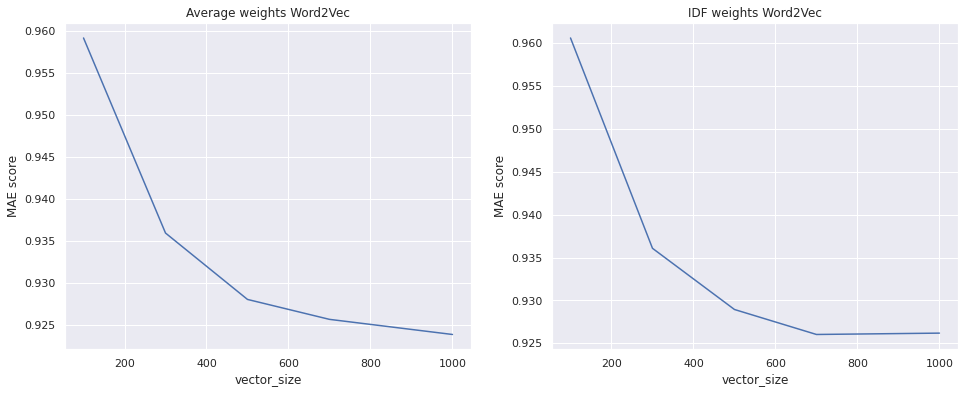

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(vector_sizes, mae)
ax[0].set_xlabel('vector_size')
ax[0].set_ylabel('MAE score')
ax[0].set_title('Average weights Word2Vec')

ax[1].plot(vector_sizes_idf, mae_idf)
ax[1].set_xlabel('vector_size')
ax[1].set_ylabel('MAE score')
ax[1].set_title('IDF weights Word2Vec')
plt.show()

#### Сравнение с обучением на других эмбеддингах

Теперь попробуем обучить логистическую или линейную регрессию на любых других эмбеддингах размерности 300 и сравните качество с Word2Vec.

**Попробуем обучить две модели отдельно для положительных и отрицательных отзывов и усреднить результат**

In [ ]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 4.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sklearn import utils
from tqdm import tqdm

In [ ]:
# применение doc2vec
# https://www.machinelearningmastery.ru/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4/

class Doc2Vec_wrapper():
    def vec_for_learning(self, embedding_model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], 
                                     embedding_model.infer_vector(
                                         doc_words=doc.words, epochs=20, alpha=0.025)) for doc in sents])
        return targets, regressors

    def tokenize_text(self, text):
        # lemmatization, puncuation, stop-words cleaning applied to a comment
        tokens = []
        for sent in nltk.sent_tokenize(text):
            for word in nltk.word_tokenize(sent):
                if len(word) >= 2 and word not in string.punctuation and word not in sw:
                    tokens.append(wordnet_lemmatizer.lemmatize(word.lower(), pos="v"))
        return tokens

    def create_embeddings(self, tagged, emb_model, n_epochs=30):
        emb_model.build_vocab([x for x in tqdm(tagged.values)])
        for epoch in range(n_epochs):
            emb_model.train(utils.shuffle([x for x in tqdm(tagged.values)]),
                            total_examples=len(tagged.values), epochs=1)
            emb_model.alpha -= 0.002
            emb_model.min_alpha = emb_model.alpha

    def __init__(self, dm=0, vector_size=300, **qwargs):        # Init block starts here
        self.target_mean = 0.0
        self.target_std = 1.0
        self.emb_model_pos = Doc2Vec(dm=dm, vector_size=vector_size, **qwargs)
        self.emb_model_neg = Doc2Vec(dm=dm, vector_size=vector_size, **qwargs)
        self.model_pos = Ridge()
        self.model_neg = Ridge()

    def fit(self, corpus, target):
        # target normalization
        corp = corpus.copy()
        self.target_mean = np.mean(target)
        self.target_std = np.std(target)
        new_target = (target - self.target_mean) / self.target_std
        corp['target'] = new_target

        pos_tagged = corp.apply(lambda r: TaggedDocument(
            words=self.tokenize_text(r['positive']), tags=[r['target']]), axis=1)
        self.create_embeddings(pos_tagged, self.emb_model_pos)
        y_pos, X_pos = self.vec_for_learning(self.emb_model_pos, pos_tagged)
        self.model_pos.fit(X_pos, y_pos)

        neg_tagged = corp.apply(lambda r: TaggedDocument(
            words=self.tokenize_text(r['negative']), tags=[r['target']]), axis=1)
        self.create_embeddings(neg_tagged, self.emb_model_neg)
        y_neg, X_neg = self.vec_for_learning(self.emb_model_neg, neg_tagged)
        self.model_neg.fit(X_neg, y_neg)
        

    def predict(self, corpus):
        # no embedding creation step! same models
        pos_tagged = corpus[['positive']].apply(lambda r: TaggedDocument(
            words=self.tokenize_text(r['positive']), tags=[1]), axis=1)
        y_pos, X_pos = self.vec_for_learning(self.emb_model_pos, pos_tagged)
        
        neg_tagged = corpus[['negative']].apply(lambda r: TaggedDocument(
            words=self.tokenize_text(r['negative']), tags=[1]), axis=1)
        y_neg, X_neg = self.vec_for_learning(self.emb_model_neg, neg_tagged)

        answer = self.model_pos.predict(X_pos) + self.model_neg.predict(X_neg)
        return self.target_mean + answer / 2 * self.target_std

In [ ]:
d2v_ridge = Doc2Vec_wrapper(dm=1, vector_size=300, min_count=6, window=3, negative=5, 
                            alpha=0.065, min_alpha=0.065)
d2v_ridge.fit(df_train, y_train)

100%|██████████| 75000/75000 [00:00<00:00, 2382242.96it/s]


In [ ]:
y_pred = d2v_ridge.predict(df_test)
mean_absolute_error(y_test, y_pred)

1.0466895986502913

In [ ]:
w2v_ridge = Word2Vec_wrapper(model=Ridge(), wmode='idf', vector_size=300, 
                             min_count=6, window=3, sample=6e-5)
w2v_ridge.fit(df_train, y_train)
y_pred = w2v_ridge.predict(df_test)
mean_absolute_error(y_test, y_pred)

0.9455864955051979

**Выводы** Результаты для моделей Word2Vec и Doc2Vec можно назвать сопоставимыми. Несмотря на то, что word2vec на одном наборе параметров сработал лучше, вопрос полноценного сравнения качества не закрыт - нужно оптимизировать каждую из моделей по параметрам отдельно. Doc2Vec работал дольше из-за большого количества эпох, но реализовать его успешно получилось, отлично - перейдем к трансформерам:)

#### **Submission, score**

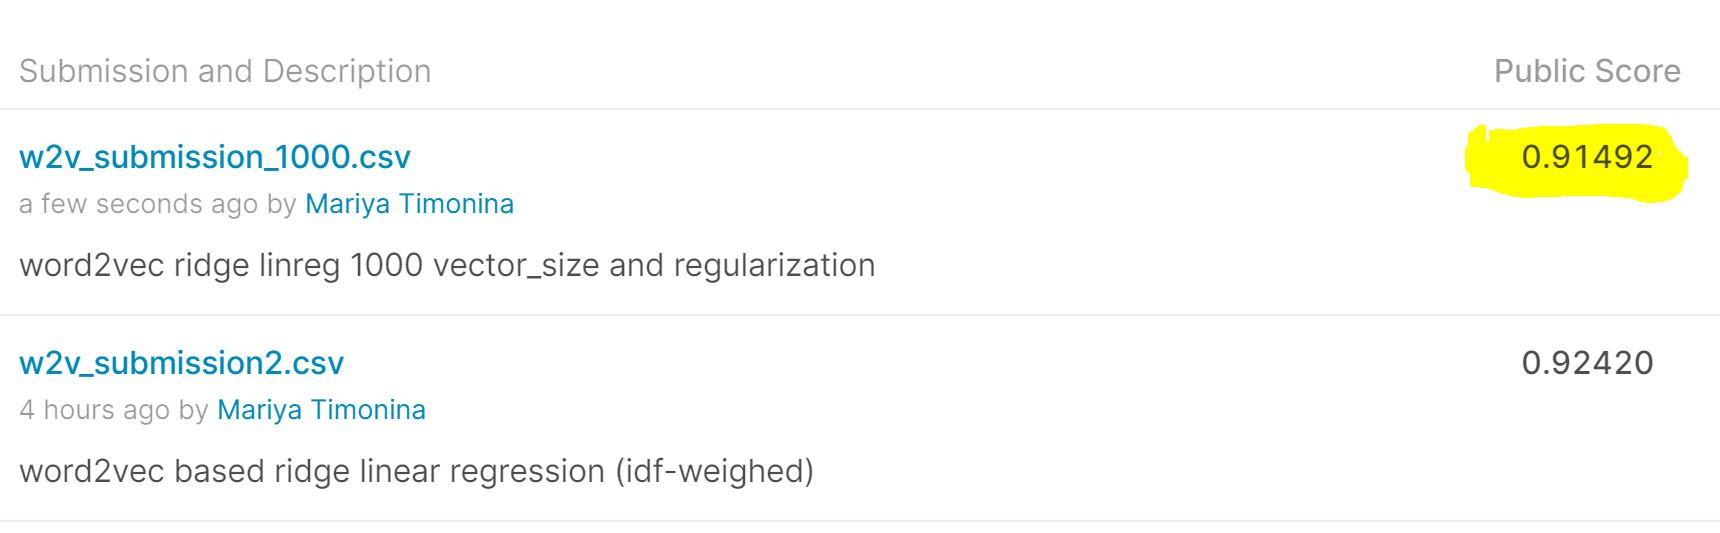

### Часть 3.

**Будем использовать дистилированный BERT с заменой последнего слоя (классификации) на полносвязный с одним выходом**

In [ ]:
import torch
from torch import nn

from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output

In [ ]:
!pip install --upgrade transformers

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.nn.utils.clip_grad import clip_grad_norm
from sklearn.metrics import mean_absolute_error

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    device = torch.device("cpu")
    print("Sadly, using CPU.")

Using GPU.


In [ ]:
def trans_process_text(text):
    return ' '.join(word for word in word_tokenize(text.lower()) if word not in string.punctuation)

PATH_TO_TRAIN_DATA = '/content/drive/MyDrive/Intro to DL (домашки Маши Тимониной)/Intro to DL HW3/train.csv'
df = pd.read_csv(PATH_TO_TRAIN_DATA)
df['negative'] = df['negative'].replace('No Negative', '').apply(trans_process_text)
df['positive'] = df['positive'].replace('No Positive', '').apply(trans_process_text)

In [ ]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# artirle: DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter (https://arxiv.org/abs/1910.01108)
pos_corpus = tokenizer(text=df['positive'].tolist(),
                       add_special_tokens=True,
                       padding='max_length',
                       truncation='longest_first',
                       max_length=100,
                       return_attention_mask=True)

neg_corpus = tokenizer(text=df['negative'].tolist(),
                       add_special_tokens=True,
                       padding='max_length',
                       truncation='longest_first',
                       max_length=100,
                       return_attention_mask=True)

input_ids = np.hstack([np.array(pos_corpus['input_ids']),
                       np.array(neg_corpus['input_ids'])])

att_mask = np.hstack([np.array(pos_corpus['attention_mask']),
                      np.array(neg_corpus['attention_mask'])])

y = df['score'].to_numpy()

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
from sklearn.preprocessing import StandardScaler

input_train, input_test, y_train, y_test = train_test_split(input_ids, y, random_state=1412)
masks_train, masks_test, y_train, y_test = train_test_split(att_mask, y, random_state=1412)

target_scaler = StandardScaler()
target_scaler.fit(y_train.reshape(-1, 1))
y_train = target_scaler.transform(y_train.reshape(-1, 1))
y_test = target_scaler.transform(y_test.reshape(-1, 1))

In [ ]:
def creating_dataloader(inputs, masks, labels, batch_size, need_shuffling=False):
    dataset = TensorDataset(torch.tensor(inputs), 
                            torch.tensor(masks),
                            torch.tensor(labels))
    return DataLoader(dataset, batch_size=batch_size, shuffle=need_shuffling)

batch_size = 32
train_dataloader = creating_dataloader(input_train, masks_train, 
                                       y_train, batch_size, need_shuffling=True)
val_dataloader = creating_dataloader(input_test, masks_test, y_test, batch_size)

In [ ]:
class EngBERTRegressor(nn.Module):
    def __init__(self):
        super(EngBERTRegressor, self).__init__()
        self.engbert = AutoModelForSequenceClassification.from_pretrained( \
                                                          "distilbert-base-uncased")
        self.engbert.classifier = nn.Linear(768, 1)

    def forward(self, input_ids, att_masks):
        # https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification
        return self.engbert(input_ids, att_masks)[0]


In [ ]:
model = EngBERTRegressor()
model.to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

EngBERTRegressor(
  (engbert): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ff

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 2
criterion = nn.L1Loss(reduction='mean')
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,       
                 num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
from torch.nn.utils.clip_grad import clip_grad_norm

def train_one_epoch(model, optimizer, criterion, train_dataloader, device, clip_value=2):
    model.train()
    for batch in tqdm(train_dataloader):  
        batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
        model.zero_grad()
        outputs = model(batch_inputs, batch_masks)           
        loss = criterion(outputs.squeeze(), batch_labels.squeeze())
        loss.backward()
        clip_grad_norm(model.parameters(), clip_value)
        optimizer.step()
        scheduler.step()
    return model


def evaluate(model, val_dataloader, device):
    model.eval()
    output, true_output = [], []
    for batch in tqdm(val_dataloader):
        batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model(batch_inputs, batch_masks).view(1,-1).tolist()[0]
        true_output += batch_labels
    return mean_absolute_error(target_scaler.inverse_transform(np.array(output).reshape(-1, 1)), 
                               target_scaler.inverse_transform(np.array(true_output).reshape(-1, 1)))


def train(model, optimizer, scheduler, criterion, n_epochs, 
          train_dataloader, val_dataloader, device, clip_value=2):
    for epoch in range(1, n_epochs + 1):
        print('Epoch ', epoch)
        print("-----")
        train_one_epoch(model, optimizer, criterion, 
                        train_dataloader, device, clip_value)
        mae = evaluate(model, val_dataloader, device)
        print('Val MAE score after ', epoch, ': ', mae)
                
    return model


def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in tqdm(dataloader):
        batch_inputs, batch_masks, _ = tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model(batch_inputs, batch_masks).view(1,-1).tolist()[0]
    return output

In [ ]:
model = train(model, optimizer, scheduler, criterion, epochs, 
              train_dataloader, val_dataloader, device, clip_value=2)

Epoch  1
-----


100%|██████████| 2344/2344 [40:41<00:00,  1.04s/it]


Val MAE score after  1 :  0.7297784806206385
Epoch  2
-----


  1%|          | 22/2344 [00:23<42:05,  1.09s/it]


KeyboardInterrupt: ignored

In [ ]:
train_one_epoch(model, optimizer, criterion, train_dataloader, device, clip_value=2)

100%|██████████| 2344/2344 [40:40<00:00,  1.04s/it]


In [ ]:
mae = evaluate(model, val_dataloader, device)
print('Val MAE score after Epoch 2', ': ', mae)

100%|██████████| 782/782 [05:08<00:00,  2.53it/s]


Val MAE score after Epoch 2 :  0.7064046845937993


In [ ]:
model = train_one_epoch(model, optimizer, criterion, train_dataloader, device, clip_value=2)
mae = evaluate(model, val_dataloader, device)
print('Val MAE score after Epoch 3', ': ', mae)

100%|██████████| 782/782 [05:08<00:00,  2.54it/s]


Val MAE score after Epoch 3 :  0.7064046845937993


In [ ]:
PATH_TO_TEST_DATA = '/content/drive/MyDrive/Intro to DL/test.csv'

df_real_test = pd.read_csv(PATH_TO_TEST_DATA)
df_real_test['negative'] = df_real_test['negative'].replace('No Negative', '').apply(trans_process_text)
df_real_test['positive'] = df_real_test['positive'].replace('No Positive', '').apply(trans_process_text)
df_real_test.head(10)

,review_id,negative,positive
0,00026f564b258ad5159aab07c357c4ca,other than the location everything else was ho...,just the location
1,000278c73da08f4fcb857fcfe4ac6417,no uk tv but this was a minor point as we were...,great location very comfortable clean breakfas...
2,000404f843e756fe3b2a477dbefa5bd4,a tiny noisy room very deceptively photographed,the breakfast booked the preceding night but f...
3,000a66d32bcf305148d789ac156dd512,noisy various electrical devices kicking in ra...,great location nice bathroom
4,000bf1d8c5110701f459ffbedbf0d546,,great location and friendly staff
5,000c36a6731f1e109864308a7a22be4d,,the personnel was helpfull and cheerful the ro...
6,00142074a207aba53ddcc46985f8c0c3,,standing global
7,0014e8ce0480a083abd0dca4f6d7aca7,n a,free upgrade in executive double room compleme...
8,0016fb343fddab24736d7e1d9823e9a5,staff in restaurant has problems with hearing,
9,0018a42d079fed623b58d24b0bde718b,nothing,fantastic hotel best i ve stayed in for a whil...


In [ ]:
pos_corpus_test = tokenizer(text=df_real_test['positive'].tolist(),
                       add_special_tokens=True,
                       padding='max_length',
                       truncation='longest_first',
                       max_length=100,
                       return_attention_mask=True)

neg_corpus_test = tokenizer(text=df_real_test['negative'].tolist(),
                       add_special_tokens=True,
                       padding='max_length',
                       truncation='longest_first',
                       max_length=100,
                       return_attention_mask=True)

test_input_ids = np.hstack([np.array(pos_corpus_test['input_ids']),
                       np.array(neg_corpus_test['input_ids'])])

test_att_mask = np.hstack([np.array(pos_corpus_test['attention_mask']),
                      np.array(neg_corpus_test['attention_mask'])])

In [ ]:
test_dataloader = creating_dataloader(test_input_ids,
                                      test_att_mask, 
                                      np.zeros(test_input_ids.shape[0]),
                                      batch_size)

In [ ]:
y_pred_norm = np.array(predict(model, test_dataloader, device))

100%|██████████| 625/625 [04:06<00:00,  2.53it/s]


In [ ]:
df_real_test['score'] = target_scaler.inverse_transform(y_pred_norm.reshape(-1, 1))
df_bert = df_real_test[['review_id', 'score']]
df_bert

,review_id,score
0,00026f564b258ad5159aab07c357c4ca,3.502937
1,000278c73da08f4fcb857fcfe4ac6417,9.665586
2,000404f843e756fe3b2a477dbefa5bd4,7.055622
3,000a66d32bcf305148d789ac156dd512,6.732510
4,000bf1d8c5110701f459ffbedbf0d546,9.508653
...,...,...
19995,ffe8a7190aee6e3a53ee2e0145a91555,5.753593
19996,ffea0e2b84788c9df755efe8e2bedb23,9.377046
19997,fff3997a85a1eed7ae7a937bc945fcf0,9.790803
19998,fff673fe95ab8f3a0910f112549862e2,6.878014


In [ ]:
df_bert.to_csv('/content/drive/MyDrive/Intro to DL/bert_submission_100_2epochs.csv', index=False)

In [ ]:
# train_one_epoch(model, optimizer, criterion, train_dataloader, device, clip_value=2)

## **Итоговый результат: топ-7 контеста**


 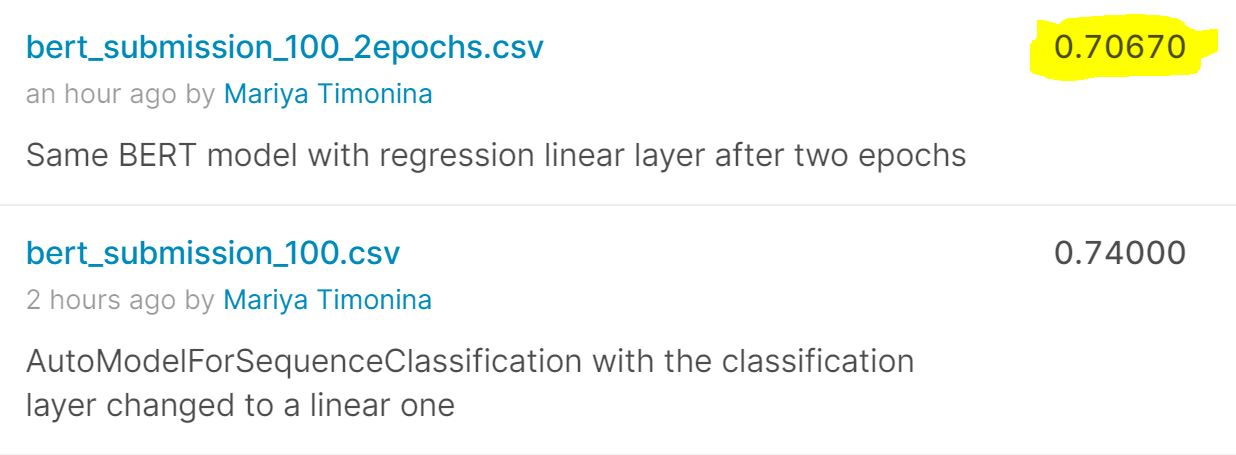